In [2]:
import sys
import os
import urllib
import time

import tensorflow as tf
from tensorflow.python.compiler.tensorrt import trt

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

from tf_trt_models.classification import download_classification_checkpoint, build_classification_graph

%matplotlib inline

ModuleNotFoundError: No module named 'tf_trt_models'

In [2]:
import ipywidgets as widgets

In [4]:
MODELS = ['mobilenet_v1_0p25_128', 'mobilenet_v1_0p5_160', 'mobilenet_v1_1p0_224', 'vgg_16', 'vgg_19', 'inception_v1',
          'inception_v2', 'inception_v3', 'inception_v4', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101',
          'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152']

w = widgets.Dropdown(options=MODELS,
                 value='mobilenet_v1_0p25_128',
                 description='model:',
                 disabled=False,)
display(w)

Dropdown(description='model:', options=('mobilenet_v1_0p25_128', 'mobilenet_v1_0p5_160', 'mobilenet_v1_1p0_224…

mobilenet_v1_0p25_128


In [9]:
MODEL = w.value
# NUM_CLASSES = 1001
NUM_CLASSES = 1000
LABELS_PATH = './data/imagenet_labels_%d.txt' % NUM_CLASSES
IMAGE_PATH = './data/dog-yawning.jpg'

### Download and preprocess image

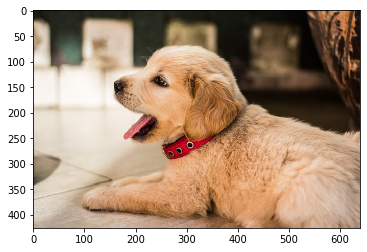

In [17]:
image = Image.open(IMAGE_PATH)

plt.imshow(image)

width = int(tf_input.shape.as_list()[1])
height = int(tf_input.shape.as_list()[2])

image = np.array(image.resize((width, height)))

### Download the checkpoint and sample image

In [10]:
checkpoint_path = download_classification_checkpoint(MODEL, 'data')

### Build the frozen graph

In [11]:
frozen_graph, input_names, output_names = build_classification_graph(
    model=MODEL,
    checkpoint=checkpoint_path,
    num_classes=NUM_CLASSES
)

W0829 20:26:32.024272 139636341868352 deprecation.py:323] From /root/.local/lib/python3.6/site-packages/tf_trt_models-0.0-py3.6.egg/tf_trt_models/classification.py:215: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0829 20:26:32.025425 139636341868352 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/graph_util_impl.py:270: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


### Create session and load graph

In [ ]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

tf.import_graph_def(trt_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_output = tf_sess.graph.get_tensor_by_name(output_names[0] + ':0')

### Execute model

In [18]:
output = tf_sess.run(tf_output, feed_dict={
    tf_input: image[None, ...]
})

scores = output[0]

### Get top 5 labels

In [19]:
with open(LABELS_PATH, 'r') as f:
    labels = f.readlines()

top5_idx = scores.argsort()[::-1][0:5]

for i in top5_idx:
    print('(%3f) %s' % (scores[i], labels[i]))

(0.534657) golden retriever

(0.155862) cocker spaniel, English cocker spaniel, cocker

(0.063501) otterhound, otter hound

(0.043757) clumber, clumber spaniel

(0.027938) standard poodle



### Bechmark Model

In [ ]:
times = []
for i in range(100):
    start_tm = time.time()
    tf_sess.run(tf_output, feed_dict={tf_input: image[None, ...]})
    times.append(time.time() - start_tm)
    
print('Inference : {0:.2f} ms'.format(np.array(times).mean() * 1000))

### Optimized the graph with TensorRT

In [13]:
converter = trt.TrtGraphConverter(
    input_graph_def=frozen_graph,
    nodes_blacklist=output_names, #output nodes
    max_batch_size=1,
    is_dynamic_op=True,
    max_workspace_size_bytes=trt.DEFAULT_TRT_MAX_WORKSPACE_SIZE_BYTES,
    precision_mode=trt.TrtPrecisionMode.FP16,
    minimum_segment_size=50)
trt_graph = converter.convert()

In [ ]:
MODEL_DIR = os.path.join(',', 'model')
if !tf.gfile.Exists(MODEL_DIR):
    tf.gfile.MkDir(MODEL_DIR)

In [14]:
base_name = os.path.splitext(os.path.basename(checkpoint_path))[0]
save_model_file_name = base_name + '_fp16.pb'
with open(os.path.join(MODEL_DIR, save_model_file_name), 'wb') as f:
    f.write(trt_graph.SerializeToString())

In [15]:
!ls ./model

dog-yawning.jpg			mobilenet_v1_1.0_224.tgz
imagenet_labels_1000.txt	mobilenet_v1_1p0_224
imagenet_labels_1001.txt	resnet_v1_50
inception_v1			resnet_v1_50_2016_08_28.tar.gz
inception_v1_2016_08_28.tar.gz	resnet_v1_50_fp16.pb


### Create session and load graph

In [16]:
tf.reset_default_graph()

trt_graph = get_frozen_graph(os.path.join(MODEL_DIR, save_model_file_name))

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

tf.import_graph_def(trt_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_output = tf_sess.graph.get_tensor_by_name(output_names[0] + ':0')

### Execute model

In [18]:
output = tf_sess.run(tf_output, feed_dict={
    tf_input: image[None, ...]
})

scores = output[0]

### Get top 5 labels

In [19]:
with open(LABELS_PATH, 'r') as f:
    labels = f.readlines()

top5_idx = scores.argsort()[::-1][0:5]

for i in top5_idx:
    print('(%3f) %s' % (scores[i], labels[i]))

(0.534657) golden retriever

(0.155862) cocker spaniel, English cocker spaniel, cocker

(0.063501) otterhound, otter hound

(0.043757) clumber, clumber spaniel

(0.027938) standard poodle



### BenchMark

In [ ]:
times = []
for i in range(100):
    start_tm = time.time()
    tf_sess.run(tf_output, feed_dict={tf_input: image[None, ...]})
    times.append(time.time() - start_tm)
    
print('Inference : {0:.2f} ms'.format(np.array(times).mean() * 1000))

### Close session to release resources

In [14]:
tf_sess.close()